# Assignment 6: Apply NB

<ol>
    <li>Minimum data points need to be considered for people having 4GB RAM is <strong>50k</strong> and for 8GB RAM is <strong>100k</strong></li>
    <li>When you are using ramdomsearchcv or gridsearchcv you need not split the data into X_train,X_cv,X_test. As the above methods use kfold. The model will learn better if train data is more so splitting to X_train,X_test will suffice.</li>
    <li>If you are writing for loops to tune your model then you need split the data into X_train,X_cv,X_test.</li>
    <li>While splitting the data explore stratify parameter. </li>
    <li><strong>Apply Multinomial NB on these feature sets</strong></li>
        <ul>
            <li>Features that need to be considered</li> 
                <dl>
                  <dt>essay</dt>
                    <dd>while encoding essay, try to experiment with the max_features and n_grams parameter of vectorizers and see if it increases AUC score.</dd>
                  <dt>categorical features</dt>
                  <dd> - teacher_prefix</dd>
                  <dd> - project_grade_category</dd>
                  <dd> - school_state</dd>
                  <dd> - clean_categories</dd>
                  <dd> - clean_subcategories</dd>
                  <dt>numerical features</dt>
                  <dd> - price</dd>
                  <dd> - teacher_number_of_previously_posted_projects</dd>
                  <dd>while encoding the numerical features check <a href='https://imgur.com/ldZA1zg'>this</a> and <a href='https://ac-classroom-production.s3.amazonaws.com/public/COMMENT/Annotation_2020-05-21_225912_0lyZzN8.jpg'>this</a></dd>
                </dl>    
            <li><font color='red'>Set 1</font>: categorical, numerical features + preprocessed_eassay (BOW)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features + preprocessed_eassay (TFIDF)</li>
        </ul>
    <li><strong>The hyper paramter tuning(find best alpha:smoothing parameter)</strong>
        <ul>
    <li>Consider alpha values in range: 10^-5 to 10^2 like [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]</li>
    <li>Explore class_prior = [0.5, 0.5] parameter which can be present in MultinomialNB function(go through <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>this</a> ) then check how results might change.
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>For hyper parameter tuning using k-fold cross validation(use GridsearchCV or RandomsearchCV)/simple cross validation data (write for loop to iterate over hyper parameter values)</li>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/hUv6aEy.jpg' width=300px><dd>-while plotting take log(alpha) on your X-axis so that it will be more readable</dd></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://imgur.com/q2P65L5.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
        <img src='https://i.imgur.com/IdN5Ctv.png' width=300px><dd>-plot the confusion matrix in heatmaps, while plotting the confusion matrix go through the <a href='https://stackoverflow.com/questions/61748441/how-to-fix-the-values-displayed-in-a-confusion-matrix-in-exponential-form-to-nor'>link </a>
</dd></li>
        </ul>
<li>find the top 20 features from either from feature <font color='red'>Set 1</font> or feature <font color='red'>Set 2</font> using values of `feature_log_prob_ ` parameter of `MultinomialNB` 
(https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) and print <strong>BOTH</strong> positive as well as negative corresponding feature names. <dd> - go through the <a href='https://imgur.com/mWvE7gj'>link </a> </dd>
    </li>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

In [1]:
# mounting th google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<h1>2. Naive Bayes </h1>

## 1.1 Loading Data

In [124]:
# load the dataset
import pandas
data = pandas.read_csv('/content/drive/My Drive/AAIC_datasets/knn_nb/preprocessed_data.csv')
data = data.head(100000)

In [125]:
# overview of dataset
data.head(5)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74


In [126]:
# feature names
data.columns

Index(['school_state', 'teacher_prefix', 'project_grade_category',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price'],
      dtype='object')

In [127]:
# feature matrix and target matrix
y = data['project_is_approved'].values
X = data.drop(['project_is_approved'], axis=1)
X.head(1)


,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05


<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [128]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)

<h2>1.3 Make Data Model Ready: encoding eassay, and project_title</h2>

In [129]:
# to store the encoded feature names after vectorizing ecah feature
features_after_encoding =list()

In [130]:
# countvectorize the essay column 
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer.fit(X_train['essay'].values)
X_train_essay_bow = vectorizer.transform(X_train['essay'].values)
X_test_essay_bow = vectorizer.transform(X_test['essay'].values)
features_after_encoding.extend(vectorizer.get_feature_names())

<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

In [131]:
# one hot encoding on school_state
vectorizer = CountVectorizer()
vectorizer.fit(X_train['school_state'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_state_ohe = vectorizer.transform(X_train['school_state'].values)
X_test_state_ohe = vectorizer.transform(X_test['school_state'].values)
features_after_encoding.extend(vectorizer.get_feature_names())

In [132]:
# one hot encoding on tecaher_prefix
vectorizer = CountVectorizer()
vectorizer.fit(X_train['teacher_prefix'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_teacher_ohe = vectorizer.transform(X_train['teacher_prefix'].values)
X_test_teacher_ohe = vectorizer.transform(X_test['teacher_prefix'].values)
features_after_encoding.extend(vectorizer.get_feature_names())

In [133]:
# one hot encoding on project_grade _category
vectorizer = CountVectorizer()
vectorizer.fit(X_train['project_grade_category'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_grade_ohe = vectorizer.transform(X_train['project_grade_category'].values)
X_test_grade_ohe = vectorizer.transform(X_test['project_grade_category'].values)
features_after_encoding.extend(vectorizer.get_feature_names())

In [134]:
# one hot encoding on clean_categories
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_categories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_category_ohe = vectorizer.transform(X_train['clean_categories'].values)
X_test_category_ohe = vectorizer.transform(X_test['clean_categories'].values)
features_after_encoding.extend(vectorizer.get_feature_names())

In [135]:
# one hot encoding on clean_subcategories
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_subcategories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_sub_category_ohe = vectorizer.transform(X_train['clean_subcategories'].values)
X_test_sub_category_ohe = vectorizer.transform(X_test['clean_subcategories'].values)
features_after_encoding.extend(vectorizer.get_feature_names())

In [136]:
# normalize price column
from sklearn.preprocessing import Normalizer
vectorizer = Normalizer()
vectorizer.fit(X_train['price'].values.reshape(1,-1)) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_price_std = vectorizer.transform(X_train['price'].values.reshape(1,-1))
X_test_price_std = vectorizer.transform(X_test['price'].values.reshape(1,-1))

X_train_price_std = X_train_price_std.reshape(-1,1)
X_test_price_std = X_test_price_std.reshape(-1,1)
features_after_encoding.append('price')


In [137]:
# normalize teacher_number_of_previously_posted_projects
vectorizer = Normalizer()
vectorizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1)) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_teacher_std = vectorizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
X_test_teacher_std = vectorizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

X_train_teacher_std = X_train_teacher_std.reshape(-1,1)
X_test_teacher_std = X_test_teacher_std.reshape(-1,1)
features_after_encoding.append('teacher_number_of_previously_posted_projects')

In [138]:
# preparing final X_train and X_test
from scipy.sparse import hstack
X_tr = hstack((X_train_essay_bow, X_train_state_ohe, X_train_teacher_ohe, X_train_grade_ohe,X_train_category_ohe,X_train_sub_category_ohe, X_train_price_std,X_train_teacher_std)).tocsr()
X_te = hstack((X_test_essay_bow, X_test_state_ohe, X_test_teacher_ohe, X_test_grade_ohe,X_test_category_ohe,X_test_sub_category_ohe, X_test_price_std, X_test_teacher_std)).tocsr()

In [139]:
# overview of encoded dataset
print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(67000, 5101) (67000,)
(33000, 5101) (33000,)


<h2>1.5 Appling NB on different kind of featurization as mentioned in the instructions</h2>

<br>Apply NB on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

## NB on BOW featurization

## Hyper Parameter Tuning 

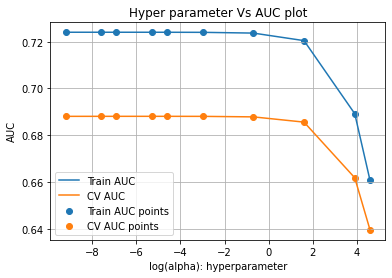

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
3,0.072540,0.000467,0.025627,0.000209,0.0001,{'alpha': 0.0001},0.686362,0.692294,0.685619,0.688092,0.002987,5,0.724631,0.723061,0.724465,0.724052,0.000704
6,0.072369,0.001377,0.025568,0.000053,0.0005,{'alpha': 0.0005},0.686380,0.692294,0.685619,0.688097,0.002983,4,0.724629,0.723061,0.724464,0.724051,0.000703
9,0.072145,0.000472,0.025526,0.000184,0.001,{'alpha': 0.001},0.686385,0.692293,0.685619,0.688099,0.002982,3,0.724627,0.723061,0.724464,0.724051,0.000703
7,0.072882,0.001679,0.025679,0.000336,0.005,{'alpha': 0.005},0.686396,0.692292,0.685616,0.688101,0.002980,1,0.724623,0.723058,0.724461,0.724047,0.000703
4,0.074143,0.002957,0.025727,0.000230,0.01,{'alpha': 0.01},0.686401,0.692289,0.685612,0.688101,0.002979,2,0.724618,0.723054,0.724458,0.724043,0.000703


In [140]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import pandas as pd

n_b = MultinomialNB()
parameters = {'alpha':[0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]}
clf = RandomizedSearchCV(n_b , parameters, cv=3, scoring='roc_auc',return_train_score=True)
clf.fit(X_tr, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_alpha'])
train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
alpha = results['param_alpha']
log_alpha =  np.log(results['param_alpha'].astype('float'))

plt.plot(log_alpha, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(log_alpha, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(log_alpha, train_auc, label='Train AUC points')
plt.scatter(log_alpha, cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("log(alpha): hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

results.head()

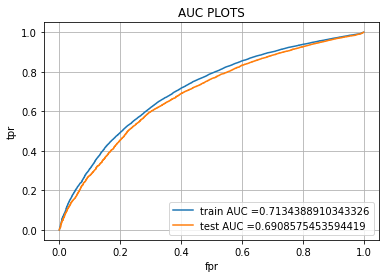

In [143]:
# the best_alpha is 1.0
best_alpha = 0.005
from sklearn.metrics import roc_curve, auc
n_b = MultinomialNB(alpha = best_alpha)
n_b.fit(X_tr, y_train)
y_train_proba = n_b.predict_proba(X_tr)[:,1]
y_test_proba = n_b.predict_proba(X_te)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_proba)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_proba)
# plot train auc and test auc curve
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("AUC PLOTS")
plt.grid()
plt.show()

In [144]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [145]:
# create confusion matrix
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_proba, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_proba, best_t)))

the maximum value of tpr*(1-fpr) 0.43755676072774474 for threshold 0.852
Train confusion matrix
[[ 6824  3349]
 [19759 37068]]
Test confusion matrix
[[ 3215  1795]
 [ 9792 18198]]


In [146]:
# top features for negative class
negative_class_log_proba = n_b.feature_log_prob_[0]
top_negative_indices = negative_class_log_proba.argsort()[::-1][:20]
print("Top Features for Negative class are : ")
print(",".join(map(str,list(map(features_after_encoding.__getitem__, top_negative_indices)))))

Top Features for Negative class are : 
students,school,learning,my,classroom,not,learn,they,the,help,my students,nannan,many,we,need,work,come,love,reading,materials


In [147]:
# top features for positive class
positive_class_log_proba = n_b.feature_log_prob_[1]
top_positive_indices = positive_class_log_proba.argsort()[::-1][:20]
print("Top Features for positive class are : ")
print(",".join(map(str,list(map(features_after_encoding.__getitem__, top_positive_indices)))))

Top Features for positive class are : 
students,school,my,learning,classroom,the,not,they,my students,learn,help,many,nannan,we,work,need,reading,use,love,day


In [148]:
# maintaining the summary
from prettytable import PrettyTable
summary = PrettyTable()
summary.field_names = ["Vectorizer", "Model", "alpha", "AUC"]
summary.add_row(["BOW","Naive Bayes",best_alpha, auc(test_fpr, test_tpr)])

## NB on TFIDF Featuriazation

### convert essay to TFIDF Vector

In [149]:
# doing TF-IDF vectorization on essay
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer.fit(X_train['essay'].values)
X_train_essay_tfidf = vectorizer.transform(X_train['essay'].values)
X_test_essay_tfidf = vectorizer.transform(X_test['essay'].values)

In [150]:
# preparing the final encoded dataframe
from scipy.sparse import hstack
X_tr = hstack((X_train_essay_tfidf, X_train_state_ohe, X_train_teacher_ohe, X_train_grade_ohe,X_train_category_ohe,X_train_sub_category_ohe, X_train_price_std,X_train_teacher_std)).tocsr()
X_te = hstack((X_test_essay_tfidf, X_test_state_ohe, X_test_teacher_ohe, X_test_grade_ohe,X_test_category_ohe,X_test_sub_category_ohe, X_test_price_std, X_test_teacher_std)).tocsr()

#### Hyper Parameter Tuning

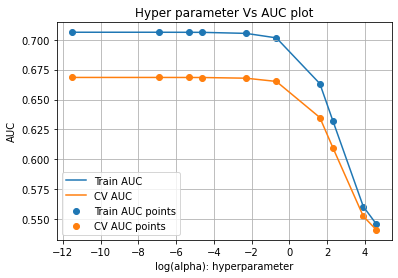

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
5,0.066170,0.000276,0.025034,0.000166,1e-05,{'alpha': 1e-05},0.663548,0.674486,0.667423,0.668486,0.004528,1,0.706407,0.706253,0.706146,0.706269,0.000107
8,0.066671,0.000248,0.025212,0.000287,0.001,{'alpha': 0.001},0.663542,0.674479,0.667415,0.668479,0.004528,2,0.706399,0.706243,0.706137,0.706260,0.000108
9,0.066228,0.000033,0.025120,0.000040,0.005,{'alpha': 0.005},0.663517,0.674450,0.667385,0.668451,0.004527,3,0.706365,0.706202,0.706100,0.706222,0.000109
4,0.066180,0.000074,0.026160,0.001498,0.01,{'alpha': 0.01},0.663489,0.674416,0.667347,0.668417,0.004525,4,0.706318,0.706150,0.706053,0.706174,0.000109
3,0.066396,0.000792,0.025153,0.000225,0.1,{'alpha': 0.1},0.663050,0.673794,0.666716,0.667853,0.004459,5,0.705527,0.705221,0.705217,0.705322,0.000145


In [151]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import pandas as pd

n_b = MultinomialNB()
parameters = {'alpha':[0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]}
clf = RandomizedSearchCV(n_b , parameters, cv=3, scoring='roc_auc',return_train_score=True)
clf.fit(X_tr, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_alpha'])
train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
alpha = results['param_alpha']
log_alpha =  np.log(results['param_alpha'].astype('float'))

plt.plot(log_alpha, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(log_alpha, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(log_alpha, train_auc, label='Train AUC points')
plt.scatter(log_alpha, cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("log(alpha): hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

results.head()

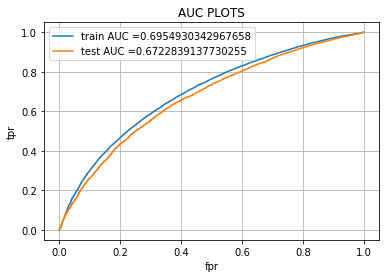

In [154]:
best_alpha = 0.00001
from sklearn.metrics import roc_curve, auc
n_b = MultinomialNB(alpha = best_alpha)
n_b.fit(X_tr, y_train)
y_train_proba = n_b.predict_proba(X_tr)[:,1]
y_test_proba = n_b.predict_proba(X_te)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_proba)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_proba)
# pot train auc and test auc
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("AUC PLOTS")
plt.grid()
plt.show()

In [155]:
# confusion matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_proba, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_proba, best_t)))

the maximum value of tpr*(1-fpr) 0.415854886039469 for threshold 0.849
Train confusion matrix
[[ 6653  3520]
 [20692 36135]]
Test confusion matrix
[[ 3147  1863]
 [10282 17708]]


In [156]:
# top 20 features of negative class
negative_class_log_proba = n_b.feature_log_prob_[0]
top_negative_indices = negative_class_log_proba.argsort()[::-1][:20]
print("Top Features for Negative class are : ")
print(",".join(map(str,list(map(features_after_encoding.__getitem__, top_negative_indices)))))

Top Features for Negative class are : 
mrs,literacy_language,grades_prek_2,math_science,ms,grades_3_5,mathematics,literacy,literature_writing,grades_6_8,specialneeds,specialneeds,ca,health_sports,appliedlearning,students,appliedsciences,grades_9_12,music_arts,mr


In [157]:
# top 20 features of positive class
positive_class_log_proba = n_b.feature_log_prob_[1]
top_positive_indices = positive_class_log_proba.argsort()[::-1][:20]
print("Top Features for positive class are : ")
print(",".join(map(str,list(map(features_after_encoding.__getitem__, top_positive_indices)))))

Top Features for positive class are : 
mrs,literacy_language,grades_prek_2,math_science,ms,grades_3_5,literacy,mathematics,literature_writing,grades_6_8,ca,health_sports,students,specialneeds,specialneeds,appliedlearning,health_wellness,grades_9_12,mr,appliedsciences


In [158]:
# adding results to summary
summary.add_row(["TFIDF","Naive Bayes",best_alpha, auc(test_fpr, test_tpr)])

<h1>3. Summary</h1>

In [159]:
print(summary)

+------------+-------------+-------+--------------------+
| Vectorizer |    Model    | alpha |        AUC         |
+------------+-------------+-------+--------------------+
|    BOW     | Naive Bayes | 0.005 | 0.6908575453594419 |
|   TFIDF    | Naive Bayes | 1e-05 | 0.6722839137730255 |
+------------+-------------+-------+--------------------+
